# Consigna 5
## Importación de modulos
---

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from columns_to_keep import C2K
from type_to_fix import T2F

## Carga de la tabla de metadata
---

In [2]:
data_dir = os.path.join('..', 'dataset')
data_file_name = 'datadump-20150801-20171219.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
df = pd.read_csv(full_data_file_name)
display(df.shape)

(63265, 111)

### Preprocesamiento o curación de la metadata### Preprocesamiento o curación de la metadata

In [3]:
# Remuevo espacios al inicio y final del nombre de la columna
df.columns = [column.strip() for column in df.columns]

# Tomo solo las columnas que vamos a necesitar
df = df[C2K]

# Se corrigen los tipos de los datos 
df = df.astype(T2F)

display(df.shape)

(63265, 39)

## Carga la tabla de mensajes preprocesados
---

In [13]:
data_file_name = 'tiny_yup_messages_preprocessed.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
dfd = pd.read_csv(full_data_file_name)
display(dfd.shape)

(7441, 6)

## Cálculos
---

### Cálculo del número de turnos de estudiantes por dialogo
#### Pasos:

1. Cueta el numeor de turnos agrupando por `session_id` y `sent_from`
2. Se descartan las filas que no son turnos del tutor o estudiante
3. Se crea una conlumna con el el label adecuado
4. Se remueven las columnas no necesarias

In [14]:
# 1.
st_turnos = dfd.groupby(['session_id','sent_from']).count().reset_index()

# 2.
st_turnos = st_turnos[st_turnos.sent_from=='student']

# 3. 
st_turnos['counts'] = st_turnos['text']

# 4.
st_turnos.drop(columns=['created_at', 'sent_to', 'content_type', 'text'], inplace=True)

st_turnos = st_turnos.dropna()

display(st_turnos)

,session_id,sent_from,counts
0,300142,student,8
4,300373,student,11
8,300477,student,10
12,300551,student,11
16,300602,student,6
...,...,...,...
1123,325522,student,19
1126,325796,student,5
1130,325896,student,9
1135,326034,student,12


### Cálculo del numero de palabras del estudiante por dialogo

1. Se genera una nueva columna con la longitud en palabras de cada diálogo
2. Se toman las columnas `session_id`, `sent_from` y la nueva columna `twlen`
3. Se selecciona el sub grupo de turnos correspondientes a los estudiantes
4. Se computa el valor medio de la cantidad de palabras por sessión
5. Se crea la columna `student_rating` con el puntaje asignado por el alumno a la session
6. Se eliminan las las filas sin informacion (N/A)
7. Se convierte a tipo entero la variable student_rating

In [12]:
# 1.
tmp = dfd
tmp['twlen'] = tmp.text.apply(lambda x: len(x))

# 2.
dialogos = tmp[['session_id', 'sent_from','twlen']]

# 3.
dialogos = dialogos[dialogos.sent_from=='student']

# 4.
dialogos = dialogos.groupby(['session_id','sent_from']).sum()
dialogos = dialogos.reset_index()

# 5.
dialogos['student_rating'] = dialogos['session_id'].apply(lambda x:df[df.session_id==x].student_rating.values[0])

# 6.
dialogos = dialogos.dropna()

# 7.
dialogos.student_rating = dialogos.student_rating.astype(int)

display(dialogos)

,session_id,sent_from,twlen,student_rating
0,300142,student,195,3
4,300602,student,315,2
6,300833,student,32,3
8,300940,student,236,5
10,301010,student,1083,5
...,...,...,...,...
252,325522,student,1688,5
253,325796,student,129,5
254,325896,student,297,5
255,326034,student,450,5


### Merge de ambos data frames para realizar computos

In [29]:
merged = pd.merge(st_turnos, dialogos, on=['session_id','sent_from'], how='inner')
merged

,session_id,sent_from,counts,twlen,student_rating
0,300142,student,8,195,3
1,300602,student,6,315,2
2,300833,student,4,32,3
3,300940,student,9,236,5
4,301010,student,22,1083,5
...,...,...,...,...,...
210,325522,student,19,1688,5
211,325796,student,5,129,5
212,325896,student,9,297,5
213,326034,student,12,450,5


<Figure size 432x288 with 0 Axes>

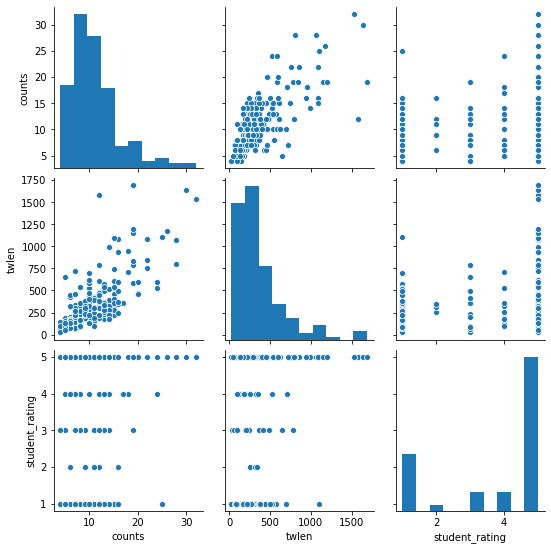

In [31]:
plt.figure()
sns.pairplot(merged[['counts','twlen','student_rating']])

In [32]:
merged[['counts','twlen', 'student_rating']].corr(method='spearman')

,counts,twlen,student_rating
counts,1.000000,0.703499,0.140110
twlen,0.703499,1.000000,0.205918
student_rating,0.140110,0.205918,1.000000
